In [6]:
import openpyxl.utils
%matplotlib inline

import torch
import pylab as plt
from munch import munchify
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader

from utils import *
from tqdm import tqdm
# from preprocessing.s02_create_dataset import load_cores_h5py

In [8]:
# project root
project_root = 'C:/Users/Mahdi/Desktop/Summer21/RA/Codes/Minh_Mahdi_mod/prostate_cancer_classification'

args = {}

# yaml configuration file location
args['config'] = '../yamls/coteaching_local_inference_Exact2D.yml'
# experiment location to load
args['exp_suffix'] = '_Patch/1e-4_onecycleNovo_fr.4numgrad6----inv.7train.4test_res10_UVA400_srs26_vs.4'
# args['exp_suffix'] = '_Patch/1e-4_onecycleNovo_fr.4numgrad6----res10_UVA400_srs26_vs.4'

# opt is a dictionary which contains all configurations
with open(args['config']) as f:
    opt = yaml.load(f, Loader)
opt.update(args)
opt = munchify(opt)
opt.project_root = project_root
opt = setup_directories(opt)

num_workers = 0
device = torch.device(f'cuda:0' if torch.cuda.is_available() else 'cpu')

In [10]:
# creating the neural network
net = construct_network(device, opt)
net = net[0]()

# loading the saved weights to it
suffix = '_1'
net.load_state_dict(torch.load(f'{opt.project_root}/{opt.paths.checkpoint_dir}/{opt.test.which_iter}_coreN{suffix}.pth'))

<All keys matched successfully>

In [11]:
# datafile to load the data. This cell and the next cell are just for having some sense of how to feed data.
# Please load your own data and make them similar to the shape of data in dataset.
data_file = '/'.join([opt.data_source.data_root, opt.data_source.test_set])
print('loading data...')
input_data = load_matlab(data_file)
print('loading done!')

loading data...
loading done!


In [12]:
# This function takes in net, device, and pair of (input, label, location) and produces output
# This is used in the next cell
def predict(net, input_data, input_label, device):
    from sklearn.metrics import confusion_matrix


    # location is not important here, so we make it up randomly
    input_location = torch.ones_like(input_label)

    outputs = []
    entropic_scores = []
    total = correct = 0
    cm = np.zeros((2,2))



    no_data = len(input_data)
    batch_size = 32
    no_batch = no_data//batch_size
    print('no batches and batch size:', no_batch, batch_size)
    # built-in function of class torch.utils.Dataset which sets model in evaluation mode
    # (here both evaluation and training are the same)
    net.eval()
    # apply model on test signals
    with torch.no_grad():
        for i in range(no_batch+1):
            strt = i*batch_size
            end = (i+1)*batch_size
            x_raw, y_batch, n_batch = input_data[strt:end,...], input_label[strt:end,...], input_location[strt:end,...]
            x_raw, y_batch, n_batch = x_raw.to(device), y_batch.to(device), n_batch.to(device)

            pred = net(x_raw, n_batch)
            pred = F.softmax(pred, dim=1)

            probabilities = pred  # torch.nn.Softmax(dim=1)(pred)
            entropies = -(probabilities * torch.log(probabilities)).sum(dim=1)
            entropic_scores.append((-entropies).cpu().numpy())

            outputs.append(pred.cpu().numpy())
            total += y_batch.size(0)
            correct += (pred.argmax(dim=1) == torch.argmax(y_batch, dim=1)).sum().item()
            # correct += ((pred[:,1]>=0.4) == torch.argmax(y_batch, dim=1)).sum().item()
            cm += confusion_matrix(y_batch.argmax(dim=1).cpu(), pred.argmax(dim=1).cpu(), labels=[0,1])

    tn, fp, fn, tp = cm.ravel()
    acc_sb = (tp/(tp+fn) + tn/(tn+fp))/2.0
    outputs = np.concatenate(outputs)
    entropic_scores = np.concatenate(entropic_scores)
    return outputs, entropic_scores, correct / total, acc_sb

def infer_core_wise2(predictions, core_len, roi_coors, ood_scores=None):
    """
    Infer core-wise predictions based on signal-wise predictions.
    Input must be 1-D array
    :param predictions: signal-wise predictions
    :param core_len: length of each core
    :param roi_coors: pixel-wise coordinates of ROI area
    :param ood_scores:
    :return:
    """
    counter = 0
    core_feat1, core_res1, core_l1, core_l2, core_ood = [], [], [], [], []
    prediction_maps = []

    # find a label for each core
    for i in range(len(core_len)):
        temp = predictions[counter:(counter + core_len[i])]
        core_res1.append(temp)
        # core_l1.append(np.greater(temp[:, 1], temp[:, 0]).sum() / core_len[i])
        core_l1.append((temp[:, 1]>=0.5).sum() / core_len[i])
        core_l2.append(temp[:, 1].sum() / core_len[i])
        temp = temp[:, 1]
        th = 0.5
        # core_feat1.append([temp[temp > th].mean(), len(temp[temp > th]), temp[temp < th].mean(), len(temp[temp < th])])
        core_ood.append(ood_scores)
        counter += core_len[i]

        # heatmap = np.zeros((roi_coors[i][0].max()+1, roi_coors[i][1].max()+1))
        # heatmap[roi_coors[i][0], roi_coors[i][1]] = core_res1[i][:, 1]
        # prediction_maps.append(heatmap)
    return core_l1, core_l2, core_ood, prediction_maps

In [13]:
def net_interpretation2(predicted_label, predicted_label2, patient_id, involvement, gleason_score, result_dir=None,
                       ood=None, cct=(0.2, 0.6, 1), cbt=(0, 1, 0.6), cf=(1, 0.2, 0.6),
                       current_epoch=None, set_name='Test', writer=None, scores: dict = None, threshold=0.5,
                       plotting=True):
    import seaborn as sns
    true_label = np.array([item > 0 for item in involvement])

    current_epoch_str = '' if current_epoch is None else f'_{current_epoch}'

    predicted_label_th = np.array(predicted_label)
    predicted_label_th[predicted_label_th > threshold] = 1
    predicted_label_th[predicted_label_th <= threshold] = 0

    andlabels = np.logical_and(predicted_label_th, true_label)

    patients = np.unique(patient_id)
    # Invs = np.ones_like(involvement)
    Invs = involvement * 100
    gs = np.array(gleason_score)
    indx = []
    maxc = 0
    for ip in patients:
        temp = np.where(patient_id == ip)[0]
        indx.append(temp)
        maxc = max(maxc, len(temp))

    inv = np.zeros((len(patients), maxc), dtype=float)
    #    cmaps=[]

    label = []
    cmap = [cf if True else [0, 0, 1] for i in range(len(true_label))]

    for i in range(len(true_label)):
        if andlabels[i] == 1:
            cmap[i] = cct
        elif (predicted_label_th[i] + true_label[i]) == 0:
            cmap[i] = cbt
        else:
            cmap[i] = cf
    cmap = np.array(cmap)
    cmaps = np.zeros((len(patients), maxc, 3), dtype=float)
    for ip in range(len(patients)):
        indxip = indx[ip]
        inv[ip, :len(indxip)] = Invs[indxip]
        cmaps[ip, :len(indxip)] = cmap[indxip]
        label.append(gs[indxip])
        for i in range(len(label[ip])):
            if label[ip][i] == 'Benign':
                inv[ip, i] = 50
                label[ip][i] = '-'
            if label[ip][i] == 'FB':
                inv[ip, i] = 50
                label[ip][i] = '-'

    fig1, ax1 = plt.subplots()
    fig1.set_size_inches(18.5, 10.5)
    barbase = np.cumsum(np.concatenate((np.zeros((inv.shape[0], 1)), inv[:, 0:-1]), axis=1), 1)

    for i in range(maxc):
        ax1.bar(np.arange(len(patients)), inv[:, i].tolist(), 0.7, bottom=barbase[:, i], color=cmaps[:, i])
        ax1.EdgeColor = 'k'
    plt.xticks(np.arange(len(patients)), patients.astype(int))
    plt.xlabel('Patient No.')

    width = np.array([p.get_width() for p in ax1.patches][0]).squeeze()
    joblblpos = inv / 2 + barbase
    for k1 in range(inv.shape[0]):
        for k2 in range(inv.shape[1]):
            plt.text(k1-width/2., joblblpos[k1, k2], label[k1][k2] if inv[k1, k2] != 0 else '')

    if plotting:
        plt.show()

    # plt.savefig(f'{result_dir}/{set_name}_acc_per_core{current_epoch_str}.png')
    ood_sum = np.array([-_ood.sum() for _ood in ood])
    ood_normalized = ood_sum / ood_sum.sum()

    fig2 = plt.figure(2)
    ax2 = sns.scatterplot(x=involvement, y=predicted_label, size=ood_normalized, legend=False)
    diag = np.arange(0, 1, .05)
    sns.lineplot(x=diag, y=diag, color='r', ax=ax2)
    ax2.axvspan(-.1, 0.1, -.1, .5, alpha=.2, facecolor='lightgreen')
    ax2.axvspan(-.1, 0.1, .51, 1., alpha=.2, facecolor='red')
    ax2.axvspan(0.11, 1.1, -.1, .5, alpha=.2, facecolor='grey')
    ax2.axvspan(0.11, 1.1, .51, 1., alpha=.2, facecolor='moccasin')
    ax2.axvline(x=.105, linewidth=.6, linestyle='--', color='black')
    ax2.axhline(y=.505, linewidth=.6, linestyle='--', color='black')
    ax2.axis('square')
    ax2.set(ylim=[-.1, 1.1], xlim=[-.1, 1.1])
    if scores is not None:
        ax1.set_title(f'ACC: {scores["acc"]:.2f} | ACC_B: {scores["acc_b"]:.2f} '
                      f'AUC: {scores["auc"]:.2f} | SEN: {scores["sen"]:.2f} | SPE: {scores["spe"]:.2f}')
        ax2.set(title=f'Correlation Coefficient = {scores["corr"]:.3f} | MAE = {scores["mae"]:.3f}',
                xlabel='True Involvement', ylabel='Predicted Involvement'
                )
    # plt.savefig('point_cloud3.png')
    if plotting:
        plt.show()

    # new plot based on new way of finding core predictions
    fig3 = plt.figure(3)
    ax3 = sns.scatterplot(x=involvement, y=predicted_label2, size=ood_normalized, legend=False)
    diag = np.arange(0, 1, .05)
    sns.lineplot(x=diag, y=diag, color='r', ax=ax3)
    ax3.axvspan(-.1, 0.1, -.1, .5, alpha=.2, facecolor='lightgreen')
    ax3.axvspan(-.1, 0.1, .51, 1., alpha=.2, facecolor='red')
    ax3.axvspan(0.11, 1.1, -.1, .5, alpha=.2, facecolor='grey')
    ax3.axvspan(0.11, 1.1, .51, 1., alpha=.2, facecolor='moccasin')
    ax3.axvline(x=.105, linewidth=.6, linestyle='--', color='black')
    ax3.axhline(y=.505, linewidth=.6, linestyle='--', color='black')
    ax3.axis('square')
    ax3.set(ylim=[-.1, 1.1], xlim=[-.1, 1.1])

    if plotting:
        plt.show()

    plt.close('all')

In [14]:
from utils.dataset import merge_split_train_val
split_rs = 26
val_size = 0.4

if split_rs>=0:
    input_data = merge_split_train_val(input_data, random_state=split_rs, val_size=val_size)

In [15]:
from utils.dataset import create_datasets_test_Exact

initial_min_inv=.8
min_inv=.4

# which dataset to use for testset. Either train, val, or test
state = 'test'
dataset, core_len, true_involvement, patient_id_bk, gs_bk, roi_coors, true_labels, *ids = create_datasets_test_Exact(
    '/'.join([opt.data_source.data_root, opt.data_source.test_set]), dataset_name=opt.data_source.dataset,
    min_inv=min_inv, input_data=input_data, state=state, norm=opt.normalize_input)

cancer labels shape (1333, 2)
data shape (3483, 1, 256, 256)


In [16]:
# these are input data and label corresponding to them
# label is just for plotts in the next cell, you can feed a random matrix of nx2 instead
x_data = dataset.tensors[0]
y_label = dataset.tensors[1]

predictions, ood_scores, acc_s, acc_sb = predict(net, x_data, y_label, device)

no batches and batch size: 108 32


c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


              ACC_S  ACC_SB    AUC  AUPRC     F1    MCC    SEN   SPE    PRE  \
Epoch = Best  0.655   0.651  0.859  0.686  0.774  0.634  0.774  0.86  0.774   

                ACC  ACC_B   CORR     MAE  
Epoch = Best  0.827  0.817  0.549  24.492  


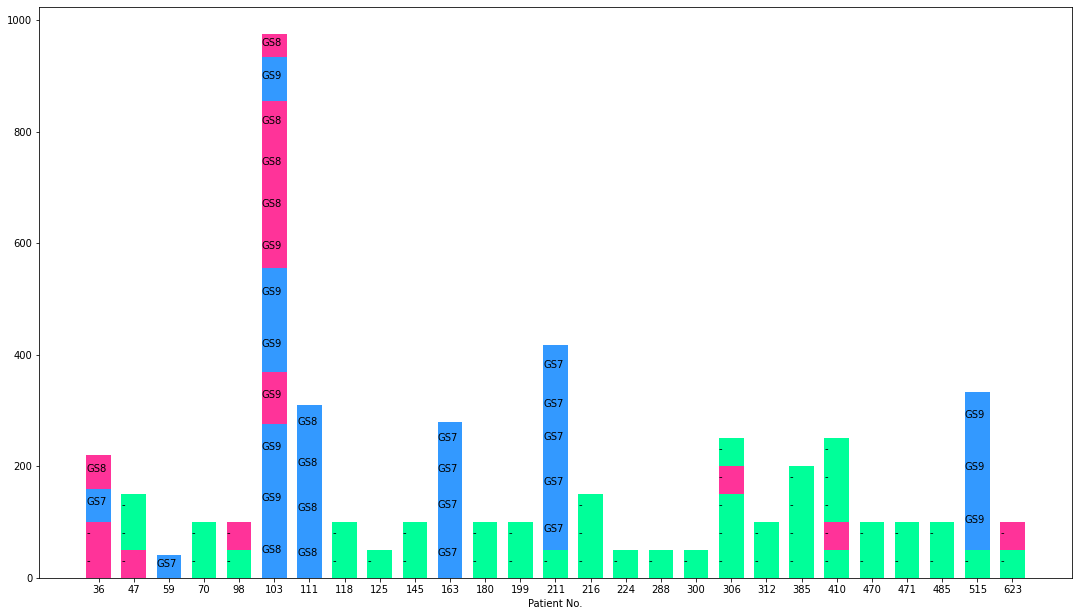

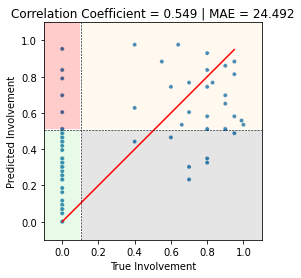

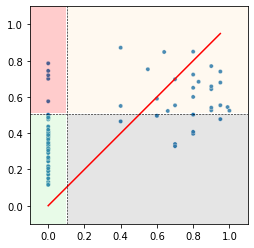

In [17]:
predicted_involvement, predicted_involvement2, ood, prediction_maps = infer_core_wise2(predictions, core_len, roi_coors,
                                                                                      ood_scores)
scores = {'acc_s': acc_s, 'acc_sb': acc_sb}
scores = compute_metrics(predicted_involvement, true_involvement,
                         current_epoch=0, verbose=True, scores=scores,
                         threshold=0.5)

net_interpretation2(predicted_involvement, predicted_involvement2, patient_id_bk,
                   true_involvement, gs_bk, opt.paths.result_dir,
                   ood=ood, current_epoch=0, set_name=state,
                   writer=False, scores=scores, threshold=0.5, plotting=True)

In [18]:
# import matplotlib.pyplot as plt
# import matplotlib.image as mpimg
# from matplotlib.colors import NoNorm
# from einops import rearrange
#
# needle = mpimg.imread('../needle.png')
#
# # needle = rearrange(needle, 'h w c -> c h w')
# # needle = (needle - np.mean(needle, axis=(0,1)))
# plt.imshow(needle, norm=NoNorm())
# plt.show()
#
# img = x_data[0,...]
# img = rearrange(img, 'c h w -> h w c')
#
# img_label = y_label[0,...]
# img_prediction = predictions[0,...]
#
#
# plt.imshow(img,cmap='gray',norm=NoNorm())
# plt.show()

In [19]:
# needle2 = needle[:,:,0]
# pred_needle = np.copy(needle)
# img = np.array(img)
# img2 = img[::4,::4]
# img_h = img2.shape[0]
# img_w = img2.shape[1]
# img_fake = np.ones_like(img2[:,:,0])
# pred_needle[376-img_h:376, 402:402+img_w, 0] += img_fake#
#
#
# plt.figure(figsize=(18.5, 10.5))
# plt.imshow(pred_needle, norm=NoNorm())
# plt.show()

In [24]:
def pred_colormap(needle_img, img, pred, patient, inv, pred_inv, gs):
    import matplotlib.pyplot as plt
    from matplotlib.colors import NoNorm
    from einops import rearrange

    pred_needle = np.copy(needle_img)
    # with or without backgroubd? Comment it and see
    pred_needle[:,:,0:3] = np.zeros_like(pred_needle[:,:,0:3])

    img = np.array(img)
    img = rearrange(img, 'b c h w -> b h w c')
    scale = 4
    img2 = img[:,::scale,::scale,:]

    no_patches = img2.shape[0]
    img_h = img2.shape[1]
    img_w = img2.shape[2]
    tip_x = 376
    tip_y = 402

    img_fake = np.ones_like(img2)
    for i in range(no_patches):
        # if i%4==0:
            img_pred = 1 if int((pred[i,1]<=0.5)) else 0
            intensity = 1*((pred[i,0] if img_pred==1 else pred[i,1]) - 0.5)

            x_pos = tip_x - i*int(19/scale)
            y_pose = tip_y + i*int(25/scale)
            pred_needle[x_pos - img_h:x_pos, y_pose:y_pose + img_w, img_pred] += intensity*img_fake[i,:,:,0] #10*img2[i,:,:,0]

    fig = plt.figure(figsize=(18.5, 10.5))
    ax = fig.add_subplot()
    ax.text(80, 60, f'Patient:{int(patient)}  '+f'Inv:{inv}  '+f'PredInv:{pred_inv:.3}  '+f'GS:{gs}',
        bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 10}, fontsize=30)
    plt.imshow(pred_needle, norm=NoNorm())
    plt.show()

    return pred_needle

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Patient: 36 Inv: 0.0 Pred:0.953


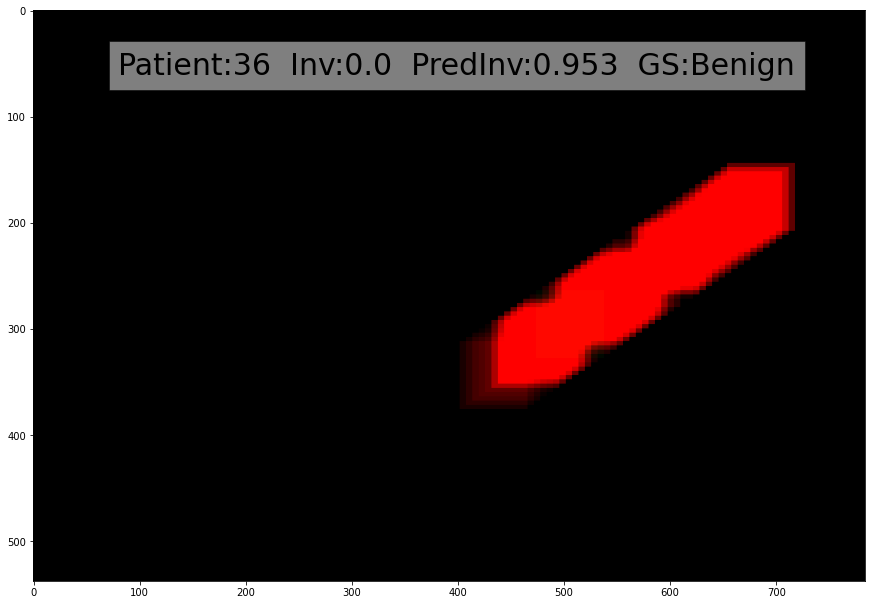

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Patient: 36 Inv: 0.0 Pred:0.512


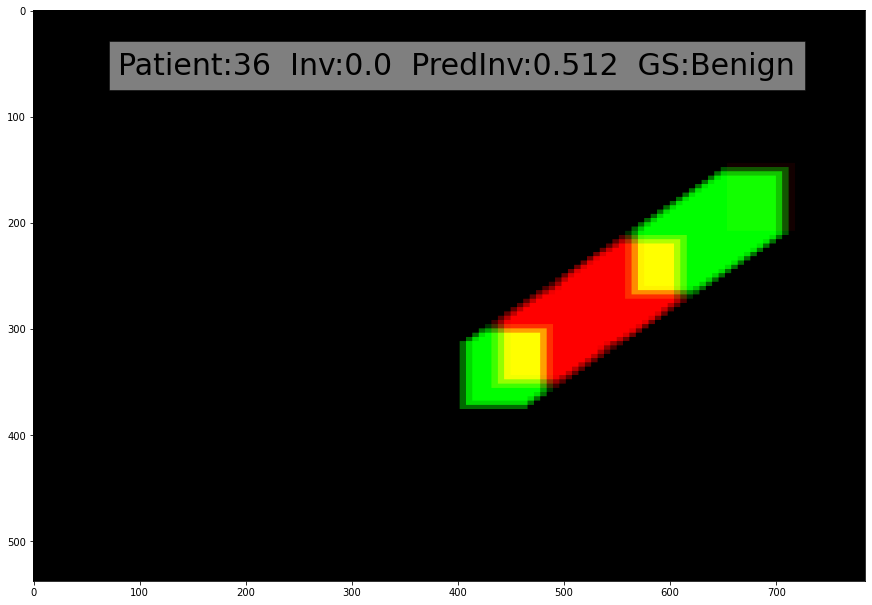

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Patient: 36 Inv: 0.6 Pred:0.744


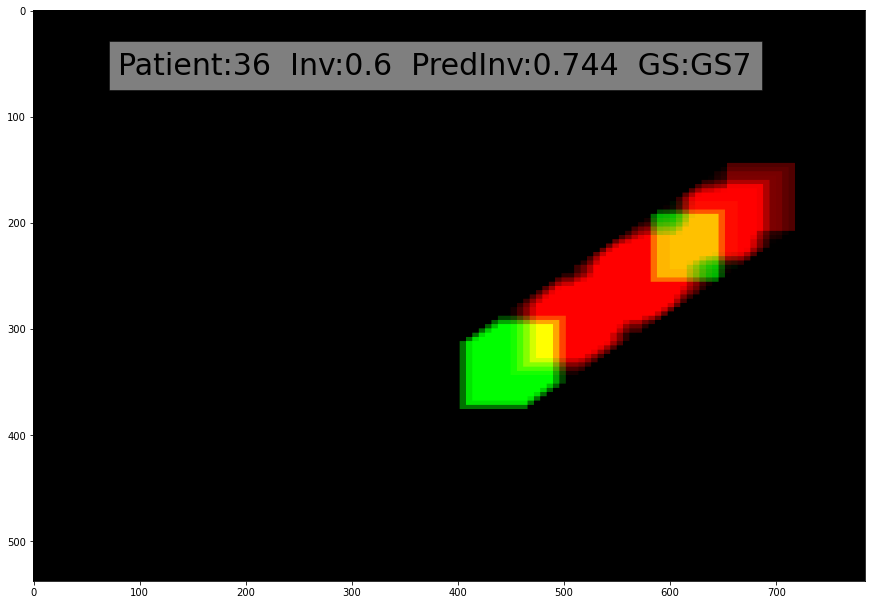

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Patient: 36 Inv: 0.6 Pred:0.465


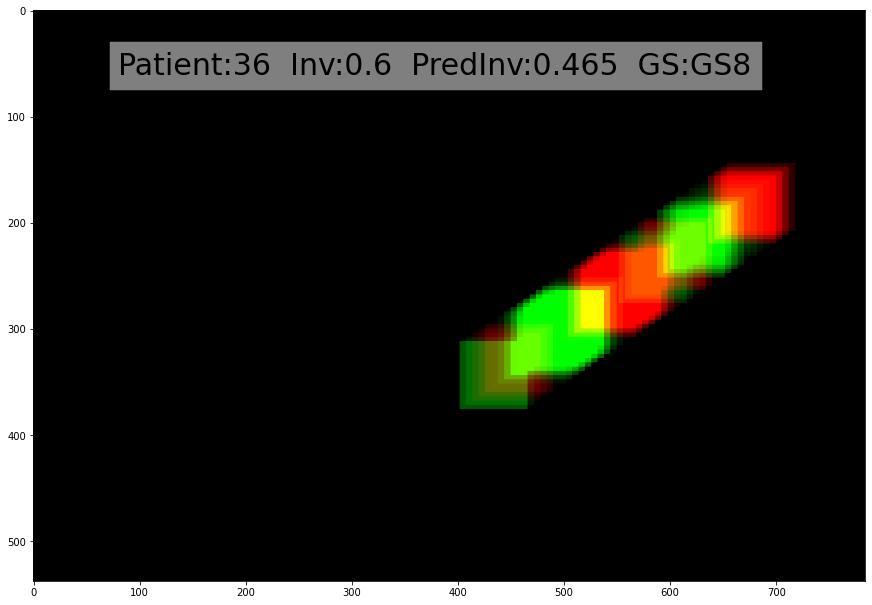

In [25]:
import matplotlib.image as mpimg
needle = mpimg.imread('../needle.png')
core_cumsum = np.cumsum(core_len)
indx, = np.where(patient_id_bk==36)
for j in indx:
    print('Patient:', int(patient_id_bk[j]), 'Inv:', true_involvement[j], f'Pred:{predicted_involvement[j]:.3}')
    start = 0 if j==0 else core_cumsum[j-1]
    end = core_cumsum[j]
    pred_colormap(needle, x_data[start:end,...], predictions[start:end,...],
                  patient_id_bk[j], true_involvement[j], predicted_involvement[j], gs_bk[j])